# MEAN-SQUARED ERROR AVEC UN MODELE XGBOOST A 7 INPUTS

## CHARGEMENT DES LIBRAIRIES

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
#!pip install category_encoders > /dev/null 2>&1
#!pip install xgboost > /dev/null 2>&1

In [3]:
import os

import numpy as np
import pandas as pd
import panel as pn

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from joblib import dump, load

/usr/local/insa/anaconda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
#create a new outputs directory
if not(os.path.isdir('./results_store/')):
    os.makedirs('./results_store/')

## PREPROCESSING

In [5]:
#data = pd.read_csv('/content/gdrive/My Drive/Defi-IA/new_result_requetes.csv')
data = pd.read_csv('./data/new_result_requetes.csv')

In [6]:
#On affecte le bon type aux variables qualitatives
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

In [7]:
#X = data[["nb_requete","date","stock","city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
#X = data[["date","stock","city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
X = data[["date","stock","city","language","hotel_id","group","brand"]]

In [8]:
Y = data[["price"]]

## DEFINITION DU MODELE

In [9]:
pipT = Pipeline(steps=[
                      ("Cat_encoder", TargetEncoder()),
                      ("Standard_scaler", StandardScaler()),
                      ("Boosting", XGBRegressor(n_estimators=3000,max_depth=10)),
                      ]
               )

/home/tryoen/.local/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/tryoen/.local/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [10]:
pipT

Pipeline(steps=[('Cat_encoder', TargetEncoder()),
                ('Standard_scaler', StandardScaler()),
                ('Boosting',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=10,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=3000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [11]:
#NOMBRE DE FOLDS
B = 5

## MSE en fonction de la date pour B folds

In [12]:
date = np.linspace(0,44,45)

In [13]:
Vect_erreur = np.zeros((B,len(date),2))

for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pipT.fit(X_train, y_train)
    pred = pipT.predict(X_test)

    x = np.ravel(X_test[['date']])

    for i in range(len(x)):
        d = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,d,0] += erreur
        Vect_erreur[b,d,1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [14]:
arrayErreur = np.zeros((B,45))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

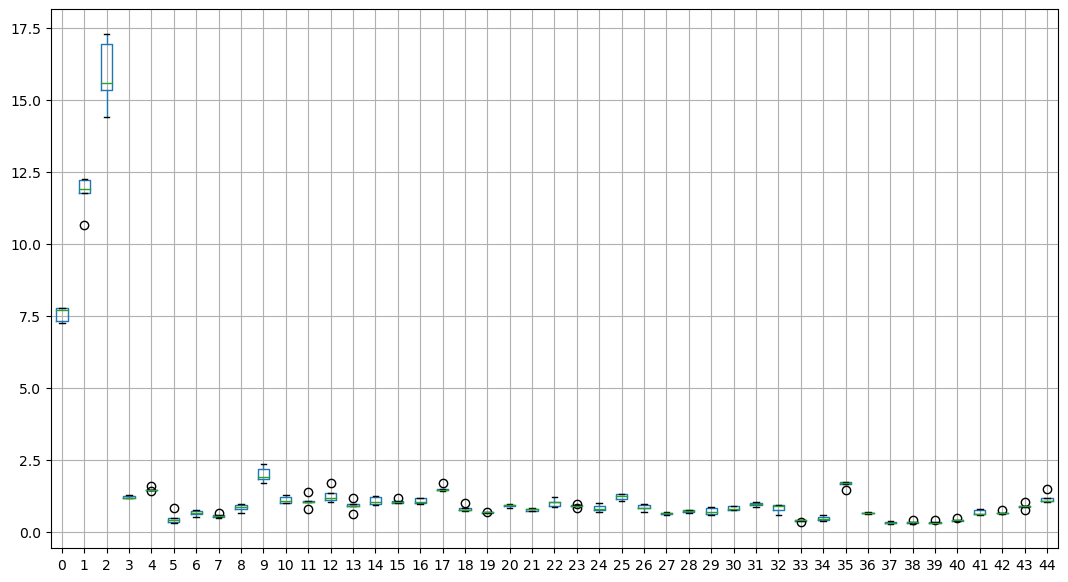

In [15]:
dataframeErreur = pd.DataFrame(arrayErreur)
plt.figure(figsize=(13,7))
dataframeErreur.boxplot()
plt.show()

In [16]:
plt.savefig('./results_store/MSE-BP-date.png')
#plt.savefig('/content/gdrive/My Drive/Defi-IA/MSE-BP-date.png')

<Figure size 640x480 with 0 Axes>

## MSE en fonction de la ville pour B folds

In [17]:
listCity = {'amsterdam':0, 'copenhagen':1, 'madrid':2, 'paris':3, 'rome':4, 'sofia':5, 'valletta':6, 'vienna':7, 'vilnius':8}

In [18]:
Vect_erreur = np.zeros((B,len(listCity),2))

for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pipT.fit(X_train, y_train)
    pred = pipT.predict(X_test)

    x = np.ravel(X_test[['city']])
    
    for i in range(len(x)):
        c = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,listCity[c],0] += erreur
        Vect_erreur[b,listCity[c],1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [19]:
arrayErreur = np.zeros((B,len(listCity)))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

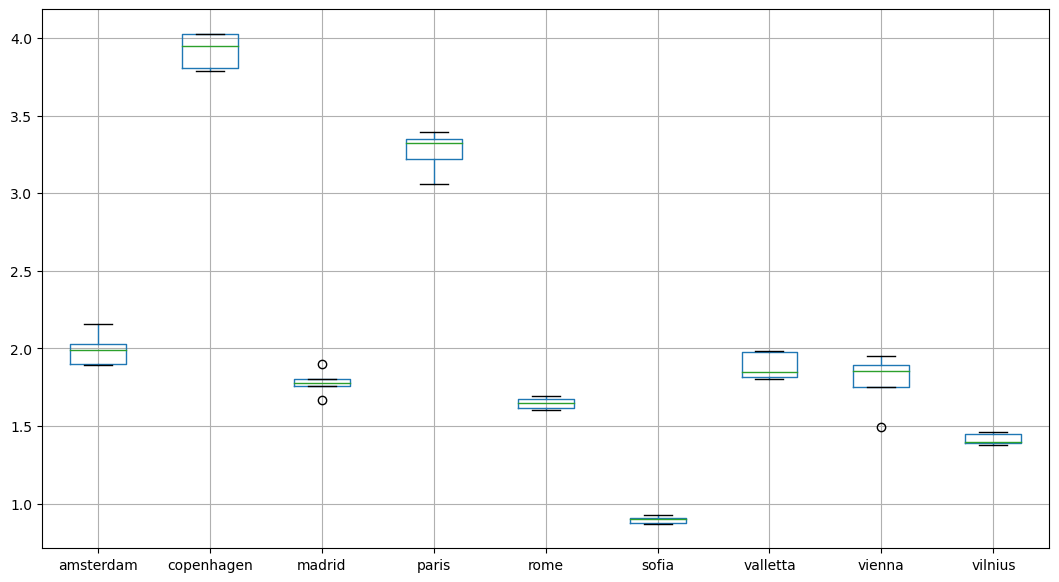

In [20]:
dataframeErreur = pd.DataFrame(arrayErreur,columns=['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius'])
plt.figure(figsize=(13,7))
dataframeErreur[['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius']].boxplot(return_type='dict')
plt.show()

In [21]:
plt.savefig('./results_store/MSE-BP-city.png')
#plt.savefig('/content/gdrive/My Drive/Defi-IA/MSE-BP-city.png')

<Figure size 640x480 with 0 Axes>

## MSE en fonction du langage pour B folds

In [22]:
listLang = {'austrian':0, 'belgian':1, 'bulgarian':2, 'croatian':3, 'cypriot':4, 'czech':5, 'danish':6, 'dutch':7, 'estonian':8, 'finnish':9,
            'french':10, 'german':11, 'greek':12, 'hungarian':13, 'irish':14, 'italian':15, 'latvian':16, 'lithuanian':17, 'luxembourgish':18, 
           'maltese':19, 'polish':20, 'portuguese':21, 'romanian':22, 'slovakian':23, 'slovene':24, 'spanish':25,'swedish':26}

In [23]:
Vect_erreur = np.zeros((B,len(listLang),2))

for b in range(0,B):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    pipT.fit(X_train, y_train)
    pred = pipT.predict(X_test)

    x = np.ravel(X_test[['language']])
    
    for i in range(len(x)):
        c = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,listLang[c],0] += erreur
        Vect_erreur[b,listLang[c],1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [24]:
arrayErreur = np.zeros((B,len(listLang)))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]

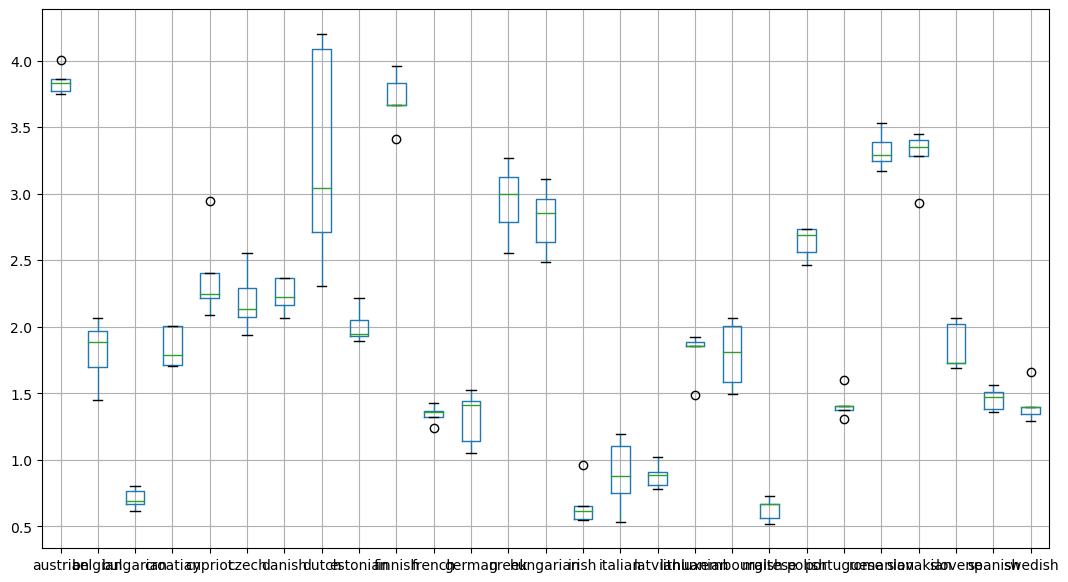

In [25]:
dataframeErreur = pd.DataFrame(arrayErreur,columns=['austrian', 'belgian', 'bulgarian', 'croatian', 'cypriot', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
            'french', 'german', 'greek', 'hungarian', 'irish', 'italian', 'latvian', 'lithuanian', 'luxembourgish', 
            'maltese', 'polish', 'portuguese', 'romanian', 'slovakian', 'slovene', 'spanish','swedish'])
plt.figure(figsize=(13,7))
dataframeErreur[['austrian', 'belgian', 'bulgarian', 'croatian', 'cypriot', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
            'french', 'german', 'greek', 'hungarian', 'irish', 'italian', 'latvian', 'lithuanian', 'luxembourgish', 
            'maltese', 'polish', 'portuguese', 'romanian', 'slovakian', 'slovene', 'spanish','swedish']].boxplot(return_type='dict')
plt.show()

In [26]:
plt.savefig('./results_store/MSE-BP-langage.png')
#plt.savefig('/content/gdrive/My Drive/Defi-IA/MSE-BP-langage.png')

<Figure size 640x480 with 0 Axes>